In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import umap
import itertools
import time
import glob
import pickle
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.axisartist.axislines import AxesZero
import matplotlib.cm as cm
import matplotlib.colors as colors

sys.path.append('/home/akumar/nse/neural_control')
from utils import apply_df_filters, calc_loadings, calc_cascaded_loadings
from loaders import load_sabes
from decoders import lr_decoder
from segmentation import reach_segment_sabes, measure_straight_dev
sys.path.append('/home/akumar/nse/neural_control/analysis_scripts')
from psth_ilmerge import get_top_neurons, get_top_neurons_alt

In [3]:
# To what extent can the neurons be separated by a combination of variance and cross-correlation with an average trace?

In [6]:
#dframe = '/home/akumar/nse/neural_control/data/indy_decoding_marginal.dat'
dframe_indy = '/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat'
dframe_loco = '/mnt/Secondary/data/postprocessed/loco_decoding_df.dat'

data_path = '/mnt/Secondary/data/sabes'
T = 30
n = 10
bin_width = 50

print('Using dframes %s, %s' % (dframe_indy, dframe_loco))

with open(dframe_indy, 'rb') as f:
    rl = pickle.load(f)
indy_df = pd.DataFrame(rl)

with open(dframe_loco, 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
loco_df = apply_df_filters(loco_df,
                        loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                        decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})
good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files)        
dimreduc_df = pd.concat([indy_df, loco_df])

top_neurons_df, loadings_df = get_top_neurons(dimreduc_df, method1='FCCA', method2='PCA', n=10, pairwise_exclude=False, data_path=data_path, T=T, bin_width=bin_width)

Using dframes /mnt/Secondary/data/postprocessed/indy_decoding_df2.dat, /mnt/Secondary/data/postprocessed/loco_decoding_df.dat


/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
35it [00:00, 46.68it/s]
35it [00:00, 1564.49it/s]


In [8]:
def get_scalar(df_, stat, neu_idx):

    if stat == 'decoding_weights':
        decoding_win = df_.iloc[0]['decoder_params']['decoding_window']
        # Restrict to velocity decoding
        c = calc_loadings(df_.iloc[0]['decoding_weights'][2:4].T, d=decoding_win)[neu_idx]
    elif stat == 'encoding_weights':
        decoding_win = df_.iloc[0]['decoder_params']['decoding_window']
        c =  calc_loadings(df_.iloc[0]['encoding_weights'], d=decoding_win)[neu_idx]        
    elif stat in ['su_r2_pos', 'su_r2_vel', 'su_r2_enc', 'su_var', 'su_act']:
        c = df_.iloc[0][stat][neu_idx]  
    elif stat == 'orientation_tuning':
        c = np.zeros(8)
        for j in range(8):
            c[j] = df_.loc[df_['bin_idx'] == j].iloc[0]['tuning_r2'][j, 2, neu_idx]
        c = np.mean(c)
        # c = odf_.iloc[0]

    return c


In [6]:
with open('/mnt/Secondary/data/postprocessed/sabes_su_calcs.dat', 'rb') as f:
    sabes_su_l = pickle.load(f)

sabes_su_df = pd.DataFrame(sabes_su_l)

# Dimensionality selection
itrim_df = loadings_df
data_files = np.unique(itrim_df['data_file'].values)
# Collect the desired single unit statistics into an array with the same ordering as those present in the loadings df
stats = ['su_var', 'su_act', 'decoding_weights', 'su_r2_enc']

carray = []
for i, data_file in enumerate(data_files):
    df = apply_df_filters(itrim_df, data_file=data_file)
    carray_ = np.zeros((df.shape[0], len(stats)))
    for j in range(df.shape[0]):                    # Find the corFrelaton between 
        for k, stat in enumerate(stats):
            # Grab the unique identifiers needed
            nidx = df.iloc[j]['nidx']
            if stat == 'orientation_tuning':
                df_ = apply_df_filters(odf, file=data_file, tau=4)
            else:
                df_ = apply_df_filters(sabes_su_df, data_file=data_file)
            carray_[j, k] = get_scalar(df_, stat, nidx)
    carray.append(carray_)


In [18]:
fbc_fraction = np.linspace(0.5, 0.95, 25)
ncv = 5
nrandom = 100
# Partition by data file
scores = np.zeros((len(fbc_fraction), len(carray), ncv))
dummy_scores = np.zeros((len(fbc_fraction), len(carray), ncv))
random_scores = np.zeros((len(fbc_fraction), len(carray), ncv, nrandom))
class_sizes = np.zeros((len(fbc_fraction), len(carray), 2))
keys = ['FCCA_loadings', 'PCA_loadings']
for ii, fbcf in tqdm(enumerate(fbc_fraction)):
    for i in range(len(carray)):
        # Per recording session
        yf_ = []
        yp_ = []

        # Is a neuron more FBC or FFC?
        ntype = []

        for j in range(2):
            df = apply_df_filters(itrim_df, data_file=data_files[i])
            x1 = df[keys[j]].values
            xx = []

            if j == 0:
                yf_.append(x1)
            else:
                yp_.append(x1)

            for k in range(carray[0].shape[1]):
                x2 = carray[i][:, k]
                xx.append(x2)
        
            xx = np.array(xx).T            

        rfbc = yf_[-1]/(yf_[-1] + yp_[-1])
        rffc = yp_[-1]/(yf_[-1] + yp_[-1])

        # do this by quantile
        cutoff = np.quantile(rfbc, fbcf)
        for n in range(rfbc.size):
            if rfbc[n] > cutoff:
                ntype.append(0)
            else:
                ntype.append(1)

        class_sizes[ii, i, 0] = np.sum(np.array(ntype) == 0)
        class_sizes[ii, i, 1] = np.sum(np.array(ntype) == 1)

        # create a logistic regression object
        logreg = LogisticRegression()
        # perform 10-fold cross-validation
        scores[ii, i] = cross_val_score(logreg, xx, ntype, cv=ncv)
        dummy_scores[ii, i] = cross_val_score(DummyClassifier(strategy='stratified'), xx, ntype, cv=ncv)

        # Compare also to 100 random assignments of neuron types
        for k in range(nrandom):
            ntype_rand = np.random.permutation(ntype)
            random_scores[ii, i, :, k] = cross_val_score(logreg, xx, ntype_rand, cv=ncv)

0it [00:00, ?it/s]

25it [12:57, 31.09s/it]


In [19]:
with open('cc_clusteringM1_results.pkl', 'wb') as f:
    f.write(pickle.dumps(scores))
    f.write(pickle.dumps(dummy_scores))
    f.write(pickle.dumps(random_scores))
    f.write(pickle.dumps(class_sizes))

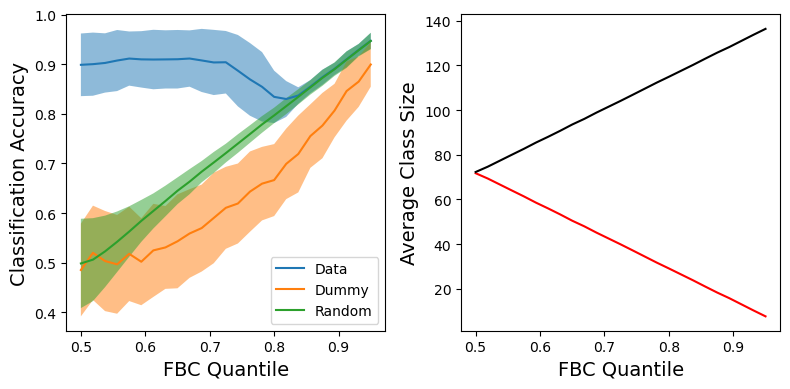

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(fbc_fraction, np.mean(scores, axis=(1, 2)))
ax[0].fill_between(fbc_fraction, np.mean(scores, axis=(1, 2)) - np.std(scores, axis=(1, 2)), np.mean(scores, axis=(1, 2)) + np.std(scores, axis=(1, 2)), alpha=0.5)

ax[0].plot(fbc_fraction, np.mean(dummy_scores, axis=(1, 2)))
ax[0].fill_between(fbc_fraction, np.mean(dummy_scores, axis=(1, 2)) - np.std(dummy_scores, axis=(1, 2)), np.mean(dummy_scores, axis=(1, 2)) + np.std(dummy_scores, axis=(1, 2)), alpha=0.5)

ax[0].plot(fbc_fraction, np.mean(random_scores, axis=(1, 2, 3)))
ax[0].fill_between(fbc_fraction, np.mean(random_scores, axis=(1, 2, 3)) - np.std(random_scores, axis=(1, 2, 3)), np.mean(random_scores, axis=(1, 2, 3)) + np.std(random_scores, axis=(1, 2, 3)), alpha=0.5)

ax[0].legend(['Data', 'Dummy', 'Random'], loc='lower right')
ax[0].set_xlabel('FBC Quantile', fontsize=14)
ax[0].set_ylabel('Classification Accuracy', fontsize=14)

ax[1].plot(fbc_fraction, np.mean(class_sizes[:, :, 0], axis=1), color='r')
ax[1].plot(fbc_fraction, np.mean(class_sizes[:, :, 1], axis=1), color='k')
ax[1].set_xlabel('FBC Quantile', fontsize=14)
ax[1].set_ylabel('Average Class Size', fontsize=14)
fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/cc_clusteringM1.pdf', bbox_inches='tight', pad_inches=1)

In [27]:
scores.shape

(25, 35, 5)

In [28]:
random_scores.shape

(25, 35, 5, 100)

In [29]:
# P-value test at 0.5
scipy.stats.mannwhitneyu(np.mean(scores[0, ...], axis=-1), np.mean(random_scores[0, ...], axis=2).ravel(), alternative='greater')

MannwhitneyuResult(statistic=6125.0, pvalue=5.270741492618746e-21)

In [30]:
# Scatter this for fbc fraction = 0.5
fbcf = 0.5
su_r = np.zeros((len(carray), 2, carray[0].shape[1]))
keys = ['FCCA_loadings', 'PCA_loadings']

X = []
Yf = []
Yp = []

# Per recording session
x_ = []
yf_ = []
yp_ = []

# Is a neuron more FBC or FFC?
ntype = []

for i in range(len(carray)):
    for j in range(2):
        df = apply_df_filters(itrim_df, data_file=data_files[i])
        x1 = df[keys[j]].values

        if j == 0:
            Yf.extend(x1)
            yf_.append(x1)
        else:
            Yp.extend(x1)
            yp_.append(x1)

        xx = []

        for k in range(carray[0].shape[1]):
            x2 = carray[i][:, k]
            xx.append(x2)
            su_r[i, j, k] = scipy.stats.spearmanr(x1, x2)[0]
    
        xx = np.array(xx).T            

    rfbc = yf_[-1]/(yf_[-1] + yp_[-1])
    rffc = yp_[-1]/(yf_[-1] + yp_[-1])

    for n in range(rfbc.size):
        if rfbc[n] > fbcf:
            ntype.append(0)
        else:
            ntype.append(1)

    # ntype.extend(np.argmax(np.vstack([rfbc[np.newaxis, :], rffc[np.newaxis, :]]), axis=0))
    X.append(xx)
    x_.append(xx)


X = np.vstack(X)
Yf = np.array(Yf)[:, np.newaxis]                                         
Yp = np.array(Yp)[:, np.newaxis]

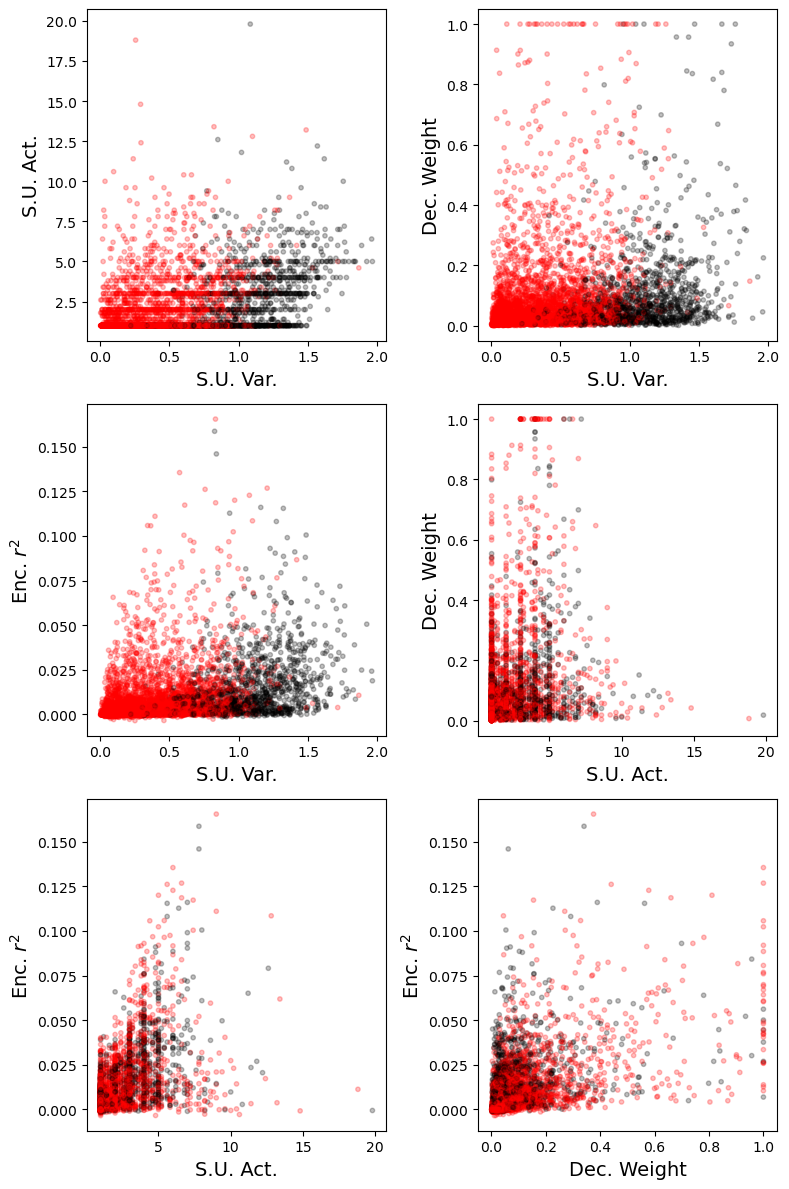

In [38]:
# Color by ntype
fig, ax = plt.subplots(3, 2, figsize=(8, 12))
colors = ['r' if n == 0 else 'k' for n in ntype]
stats = ['su_var', 'su_act', 'decoding_weights', 'su_r2_enc']
stat_strings = ['S.U. Var.', 'S.U. Act.', 'Dec. Weight', 'Enc. ' +  r'$r^2$']
for i, comb in enumerate(itertools.combinations(np.arange(4), 2)):
    a = ax[np.unravel_index(i, (3, 2))]
    a.scatter(X[:, comb[0]], X[:, comb[1]], c=colors, alpha=0.25, s=10)
    a.set_xlabel(stat_strings[comb[0]], fontsize=14)
    a.set_ylabel(stat_strings[comb[1]], fontsize=14)
fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/cc_clustering_scatterM1.pdf', bbox_inches='tight', pad_inches=1)

In [8]:
xall = []
itrim_df = loadings_df
data_files = np.unique(itrim_df['data_file'].values)
for h, data_file in enumerate(data_files):

    dat = load_sabes('%s/%s' % (data_path, data_file), boxcox=None, high_pass=False)
    dat_segment = reach_segment_sabes(dat, data_file=data_file.split('.mat')[0])
    
    T = 30
    t = np.array([t_[1] - t_[0] for t_ in dat_segment['transition_times']])
    valid_transitions = np.arange(t.size)[t >= T]

    # (Bin size 50 ms)
    time = 50 * np.arange(T)        
    # Store trajectories for subsequent pairwise analysis
    n = dat['spike_rates'].shape[-1]
    x = np.zeros((n, time.size))
    for j in range(n):
        x_ = np.array([dat['spike_rates'][0, dat_segment['transition_times'][idx][0]:dat_segment['transition_times'][idx][0] + T, j] 
                    for idx in valid_transitions])
        #x_ = StandardScaler().fit_transform(x_.T).T
        x_ = gaussian_filter1d(x_, sigma=2)
        x_ = np.mean(x_, axis=0)
        x[j, :] = x_
    xall.append(x)

Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
Reminder that start 

In [9]:
xall_stacked = np.vstack(xall)

In [10]:
# vary umap dimreduc dimensionality and other hyperparameters
# ncomp = np.arange(1, 6)
# min_dist = np.array([0.01, 0.05, 0.1, 0.2, 0.25, 0.5])
# n_neighbors = np.array([5, 25, 50, 100])
param = (4, 0.2, 50)
# Share the UMAP projection across recording sessions - measure classificationa ccuraacy per recording session
fit = umap.UMAP(min_dist=param[1], n_neighbors=param[2], n_components=param[0])
u = fit.fit_transform(xall_stacked)

In [42]:

fbc_fraction = np.linspace(0.5, 0.95, 25)
fbc_fraction = [fbc_fraction[0]]
ncv = 5
nrandom = 100
# Partition by data file
scores = np.zeros((len(fbc_fraction), len(carray), ncv))
dummy_scores = np.zeros((len(fbc_fraction), len(carray), ncv))
random_scores = np.zeros((len(fbc_fraction), len(carray), ncv, nrandom))
keys = ['FCCA_loadings', 'PCA_loadings']
indices = list(np.cumsum([len(x_) for x_ in xall]))
indices.insert(0, 0)

for ii, fbcf in tqdm(enumerate(fbc_fraction)):
    for i in range(len(xall)):

        # Per recording session
        yf_ = []
        yp_ = []

        # Is a neuron more FBC or FFC?
        ntype = []

        for j in range(2):
            df = apply_df_filters(itrim_df, data_file=data_files[i])
            x1 = df[keys[j]].values
            xx = []

            if j == 0:
                yf_.append(x1)
            else:
                yp_.append(x1)

        rfbc = yf_[-1]/(yf_[-1] + yp_[-1])
        rffc = yp_[-1]/(yf_[-1] + yp_[-1])

        # do this by quantile
        cutoff = np.quantile(rfbc, fbcf)
        for n in range(rfbc.size):
            if rfbc[n] > cutoff:
                ntype.append(0)
            else:
                ntype.append(1)

        # get the
        u_i = xall_stacked[indices[i]:indices[i+1], :]
        logreg = LogisticRegression()
        # perform 10-fold cross-validation
        scores[ii, i] = cross_val_score(logreg, u_i, ntype, cv=ncv)
        dummy_scores[ii, i] = cross_val_score(DummyClassifier(strategy='stratified'), u_i, ntype, cv=ncv)

        # Compare also to 100 random assignments of neuron types
        for k in range(nrandom):
            ntype_rand = np.random.permutation(ntype)
            random_scores[ii, i, :, k] = cross_val_score(logreg, u_i, ntype_rand, cv=ncv)

0it [00:00, ?it/s]

1it [00:27, 27.43s/it]


In [45]:
np.mean(scores)

0.9009768242504271

In [48]:
# with open('cc_clusteringM1umap_results.pkl', 'wb') as f:
#     f.write(pickle.dumps(scores))
#     f.write(pickle.dumps(dummy_scores))
#     f.write(pickle.dumps(random_scores))
#     #f.write(pickle.dumps(class_sizes))

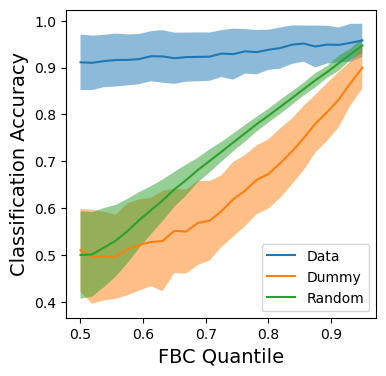

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(fbc_fraction, np.mean(scores, axis=(1, 2)))
ax.fill_between(fbc_fraction, np.mean(scores, axis=(1, 2)) - np.std(scores, axis=(1, 2)), np.mean(scores, axis=(1, 2)) + np.std(scores, axis=(1, 2)), alpha=0.5)

ax.plot(fbc_fraction, np.mean(dummy_scores, axis=(1, 2)))
ax.fill_between(fbc_fraction, np.mean(dummy_scores, axis=(1, 2)) - np.std(dummy_scores, axis=(1, 2)), np.mean(dummy_scores, axis=(1, 2)) + np.std(dummy_scores, axis=(1, 2)), alpha=0.5)

ax.plot(fbc_fraction, np.mean(random_scores, axis=(1, 2, 3)))
ax.fill_between(fbc_fraction, np.mean(random_scores, axis=(1, 2, 3)) - np.std(random_scores, axis=(1, 2, 3)), np.mean(random_scores, axis=(1, 2, 3)) + np.std(random_scores, axis=(1, 2, 3)), alpha=0.5)

ax.legend(['Data', 'Dummy', 'Random'], loc='lower right')
ax.set_xlabel('FBC Quantile', fontsize=14)
ax.set_ylabel('Classification Accuracy', fontsize=14)

# ax[1].plot(fbc_fraction, np.mean(class_sizes[:, :, 0], axis=1), color='r')
# ax[1].plot(fbc_fraction, np.mean(class_sizes[:, :, 1], axis=1), color='k')
# ax[1].set_xlabel('FBC Quantile', fontsize=14)
# ax[1].set_ylabel('Average Class Size', fontsize=14)
# fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/umap_clusteringM1.pdf', bbox_inches='tight', pad_inches=1)

In [12]:
# Visualize results using LDA

fbc_fraction = np.linspace(0.5, 0.95, 25)
ncv = 5
nrandom = 100
# Partition by data file
scores = np.zeros((len(fbc_fraction), len(carray), ncv))
dummy_scores = np.zeros((len(fbc_fraction), len(carray), ncv))
random_scores = np.zeros((len(fbc_fraction), len(carray), ncv, nrandom))
keys = ['FCCA_loadings', 'PCA_loadings']
indices = list(np.cumsum([len(x_) for x_ in xall]))
indices.insert(0, 0)

for ii, fbcf in tqdm(enumerate(fbc_fraction)):
    for i in range(len(xall)):

        # Per recording session
        yf_ = []
        yp_ = []

        # Is a neuron more FBC or FFC?
        ntype = []

        for j in range(2):
            df = apply_df_filters(itrim_df, data_file=data_files[i])
            x1 = df[keys[j]].values
            xx = []

            if j == 0:
                yf_.append(x1)
            else:
                yp_.append(x1)

        rfbc = yf_[-1]/(yf_[-1] + yp_[-1])
        rffc = yp_[-1]/(yf_[-1] + yp_[-1])

        # do this by quantile
        cutoff = np.quantile(rfbc, fbcf)
        for n in range(rfbc.size):
            if rfbc[n] > cutoff:
                ntype.append(0)
            else:
                ntype.append(1)

        # get the
        u_i = u[indices[i]:indices[i+1], :]
        #logreg = LogisticRegression()
        lda = LinearDiscriminantAnalysis(n_components=1)
        # perform 10-fold cross-validation
        scores[ii, i] = cross_val_score(lda, u_i, ntype, cv=ncv)
        dummy_scores[ii, i] = cross_val_score(DummyClassifier(strategy='stratified'), u_i, ntype, cv=ncv)

        # Compare also to 100 random assignments of neuron types
        for k in range(nrandom):
            ntype_rand = np.random.permutation(ntype)
            random_scores[ii, i, :, k] = cross_val_score(lda, u_i, ntype_rand, cv=ncv)

0it [00:00, ?it/s]

25it [04:59, 11.98s/it]


In [11]:
# with open('cc_clusteringM1umapLDA_results.pkl', 'wb') as f:
#     f.write(pickle.dumps(scores))
#     f.write(pickle.dumps(dummy_scores))
#     f.write(pickle.dumps(random_scores))
    #f.write(pickle.dumps(class_sizes))

with open('cc_clusteringM1umapLDA_results.pkl', 'rb') as f:
    scores = pickle.load(f)
    dummy_scores = pickle.load(f)
    random_scores = pickle.load(f)

fbc_fraction = np.linspace(0.5, 0.95, 25)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(fbc_fraction, np.mean(scores, axis=(1, 2)))
ax.fill_between(fbc_fraction, np.mean(scores, axis=(1, 2)) - np.std(scores, axis=(1, 2)), np.mean(scores, axis=(1, 2)) + np.std(scores, axis=(1, 2)), alpha=0.5)

ax.plot(fbc_fraction, np.mean(dummy_scores, axis=(1, 2)))
ax.fill_between(fbc_fraction, np.mean(dummy_scores, axis=(1, 2)) - np.std(dummy_scores, axis=(1, 2)), np.mean(dummy_scores, axis=(1, 2)) + np.std(dummy_scores, axis=(1, 2)), alpha=0.5)

ax.plot(fbc_fraction, np.mean(random_scores, axis=(1, 2, 3)), color='purple')
ax.fill_between(fbc_fraction, np.mean(random_scores, axis=(1, 2, 3)) - np.std(random_scores, axis=(1, 2, 3)), 
                np.mean(random_scores, axis=(1, 2, 3)) + np.std(random_scores, axis=(1, 2, 3)), alpha=0.5, color='purple')

ax.legend(['Data', 'Dummy', 'Random'], loc='lower right')
ax.set_xlabel('FBC Quantile', fontsize=14)
ax.set_ylabel('Classification Accuracy', fontsize=14)

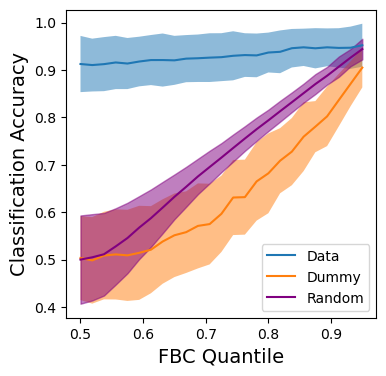

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(fbc_fraction, np.mean(scores, axis=(1, 2)))
ax.fill_between(fbc_fraction, np.mean(scores, axis=(1, 2)) - np.std(scores, axis=(1, 2)), np.mean(scores, axis=(1, 2)) + np.std(scores, axis=(1, 2)), alpha=0.5)

ax.plot(fbc_fraction, np.mean(dummy_scores, axis=(1, 2)))
ax.fill_between(fbc_fraction, np.mean(dummy_scores, axis=(1, 2)) - np.std(dummy_scores, axis=(1, 2)), np.mean(dummy_scores, axis=(1, 2)) + np.std(dummy_scores, axis=(1, 2)), alpha=0.5)

ax.plot(fbc_fraction, np.mean(random_scores, axis=(1, 2, 3)), color='purple')
ax.fill_between(fbc_fraction, np.mean(random_scores, axis=(1, 2, 3)) - np.std(random_scores, axis=(1, 2, 3)), 
                np.mean(random_scores, axis=(1, 2, 3)) + np.std(random_scores, axis=(1, 2, 3)), alpha=0.5, color='purple')

ax.legend(['Data', 'Dummy', 'Random'], loc='lower right')
ax.set_xlabel('FBC Quantile', fontsize=14)
ax.set_ylabel('Classification Accuracy', fontsize=14)

# ax[1].plot(fbc_fraction, np.mean(class_sizes[:, :, 0], axis=1), color='r')
# ax[1].plot(fbc_fraction, np.mean(class_sizes[:, :, 1], axis=1), color='k')
# ax[1].set_xlabel('FBC Quantile', fontsize=14)
# ax[1].set_ylabel('Average Class Size', fontsize=14)
# fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/umap_clusteringLDAM1.pdf', bbox_inches='tight', pad_inches=1)

In [12]:
# Run LDA on everything aggregated and visualize
# Visualize results using LDA

ncv = 5
nrandom = 100
keys = ['FCCA_loadings', 'PCA_loadings']
indices = list(np.cumsum([len(x_) for x_ in xall]))
indices.insert(0, 0)

fbcf = 0.5
# Is a neuron more FBC or FFC?
ntype = []
for i in range(len(xall)):

    # Per recording session
    yf_ = []
    yp_ = []


    for j in range(2):
        df = apply_df_filters(itrim_df, data_file=data_files[i])
        x1 = df[keys[j]].values
        xx = []

        if j == 0:
            yf_.append(x1)
        else:
            yp_.append(x1)

    rfbc = yf_[-1]/(yf_[-1] + yp_[-1])
    rffc = yp_[-1]/(yf_[-1] + yp_[-1])

    # do this by quantile
    cutoff = np.quantile(rfbc, fbcf)
    for n in range(rfbc.size):
        if rfbc[n] > cutoff:
            ntype.append(0)
        else:
            ntype.append(1)

In [13]:
lda = LinearDiscriminantAnalysis(n_components=1)

In [14]:
xtrans = lda.fit_transform(u, ntype)

In [15]:
from matplotlib import cm
from matplotlib import colors

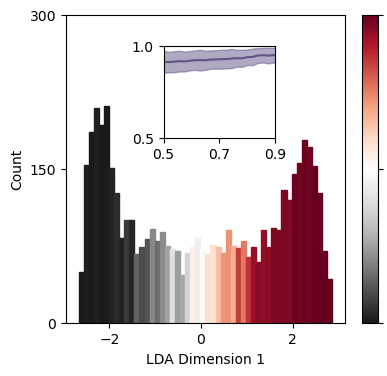

In [35]:
# Color by type
carray = cm.RdGy(range(256))
fig, ax = plt.subplots(figsize=(4.5, 4))
N, bins, patches = ax.hist(xtrans, linewidth=1, bins=50)
xbinned = np.digitize(xtrans, bins).squeeze()
# Set each rectangle to a color gradient set by the fraction of entries that belong to each type
fracs = []
for i in range(len(patches)):
    x_ = np.where(xbinned == i + 1)[0]
    if len(x_) > 0:
        ntype_ = np.array(ntype)[x_]
        frac = np.sum(ntype_)/x_.size
        patches[i].set_facecolor(carray[int(255 * frac)])
        patches[i].set_edgecolor(carray[int(255*frac)])
        fracs.append(frac)
    else:
        fracs.append(np.nan)
    #patches[i].set_facecolor(carray[0])
ax.set_xlabel('LDA Dimension 1')
ax.set_ylabel('Count')
ax.set_yticks([0, 150, 300])
#ax.set_aspect('equal')
# Vertical colorbar

cmap = cm.RdGy.reversed()
norm = colors.Normalize(vmin=0, vmax=1)
cbar= fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='vertical', label='', ticks=[0, 0.5, 1.])
cbar.ax.set_yticklabels([])

#cbar.ax.set_yticks([0, 0.5, 1.0])

# Add an inset

axin = ax.inset_axes([0.35, 0.6, 0.4, 0.3])
# axin.set_aspect(1)
axin.set_ylim([0.5, 1.0])
axin.set_xlim([0.5, 0.9])
axin.set_yticks([0.5, 1.0])
axin.set_xticks([0.5, 0.7, 0.9])
axin.plot(fbc_fraction, np.mean(scores, axis=(1, 2)), color='#625487')
axin.fill_between(fbc_fraction, np.mean(scores, axis=(1, 2)) - np.std(scores, axis=(1, 2)), np.mean(scores, axis=(1, 2)) + np.std(scores, axis=(1, 2)), alpha=0.5, color='#625487')
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/m1_lda_viz.pdf', bbox_inches='tight', pad_inches=0)

In [72]:
fracs

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9919354838709677,
 0.9825581395348837,
 0.9948979591836735,
 0.9822485207100592,
 0.995475113122172,
 0.966542750929368,
 0.9901960784313726,
 0.9572649572649573,
 0.9081632653061225,
 0.8452380952380952,
 0.86,
 0.8055555555555556,
 0.7857142857142857,
 0.7538461538461538,
 0.6833333333333333,
 0.7301587301587301,
 0.7083333333333334,
 0.647887323943662,
 0.5161290322580645,
 0.43859649122807015,
 0.4090909090909091,
 0.5573770491803278,
 0.5918367346938775,
 0.4878048780487805,
 0.5675675675675675,
 0.2830188679245283,
 0.3013698630136986,
 0.33783783783783783,
 0.25,
 0.3717948717948718,
 0.13333333333333333,
 0.1724137931034483,
 0.17142857142857143,
 0.078125,
 0.06896551724137931,
 0.07017543859649122,
 0.058823529411764705,
 0.05660377358490566,
 0.030120481927710843,
 0.016181229773462782,
 0.018421052631578946,
 0.002512562814070352,
 0.0,
 0.0,
 0.0]

### S1

In [9]:
data_path = '/mnt/Secondary/data/sabes'
T = 30
n = 10
bin_width = 50

DIM=6

# Where to save?
if len(sys.argv) > 1:
    figpath = sys.argv[1]
else:
    figpath = '/home/akumar/nse/neural_control/figs/loco_indy_merge'

good_loco_files = ['loco_20170210_03.mat',
                'loco_20170213_02.mat',
                'loco_20170215_02.mat',
                'loco_20170227_04.mat',
                'loco_20170228_02.mat',
                'loco_20170301_05.mat',
                'loco_20170302_02.mat', 'indy_20160426_01.mat']

with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    result_list = pickle.load(f)
with open('/mnt/Secondary/data/postprocessed/indy_S1_df.dat', 'rb') as f:
    rl2 = pickle.load(f)


sabes_df = pd.DataFrame(result_list)
indy_df = pd.DataFrame(rl2)
sabes_df = pd.concat([sabes_df, indy_df])
print(indy_df.iloc[0]['data_file'])

# Still need to fold the indy results into calc_single unit statistics S1
#good_loco_files.append(indy_df.iloc[0]['data_file'])

loader_arg = {'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'S1'}
decoder_arg = sabes_df.iloc[0]['decoder_args']

s1df = apply_df_filters(sabes_df, decoder_args=decoder_arg, loader_args=loader_arg)
s1df = apply_df_filters(s1df, data_file=good_loco_files)

DIM = 6

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


indy_20160426_01.mat


In [10]:
loadings_l = []
loadings_pca = []
idxs_pca = []
loadings_fca = []
idxs_fca = []
data_files = np.unique(s1df['data_file'].values)
for i, data_file in tqdm(enumerate(data_files)):

    loadings = []
    for dimreduc_method in ['LQGCA', 'PCA']:
        loadings_fold = []
        for fold_idx in range(5):  
            df_ = apply_df_filters(s1df, data_file=data_file, fold_idx=fold_idx, dim=DIM, dimreduc_method=dimreduc_method)
            if dimreduc_method == 'LQGCA':
                df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})
            try:
                assert(df_.shape[0] == 1)
            except:
                pdb.set_trace()

            V = df_.iloc[0]['coef']
            if dimreduc_method == 'PCA':
                V = V[:, 0:DIM]        
            loadings_fold.append(calc_loadings(V))

        if dimreduc_method == 'LQGCA':
            idxs_fca.extend([(i, j) for j in np.arange(loadings_fold[0].size)])
        else:
            idxs_pca.extend([(i, j) for j in np.arange(loadings_fold[0].size)])

        # Average loadings across folds
        loadings.append(np.mean(np.array(loadings_fold), axis=0))

    for j in range(loadings[0].size):
        d_ = {}
        d_['data_file'] = data_file
        d_['FCCA_loadings'] = loadings[0][j]
        d_['PCA_loadings'] = loadings[1][j]
        # d_['DCA_loadings'] = loadings[2][j]
        d_['nidx'] = j
        loadings_l.append(d_)        

    loadings_fca.extend(loadings[0])
    loadings_pca.extend(loadings[1])

loadings_df = pd.DataFrame(loadings_l)

8it [00:00, 105.15it/s]


In [11]:

itrim_df = loadings_df
data_files = np.unique(itrim_df['data_file'].values)


In [12]:
with open('/mnt/Secondary/data/postprocessed/sabes_su_calcsS1.dat', 'rb') as f:
    sabes_su_l = pickle.load(f)

sabes_su_df = pd.DataFrame(sabes_su_l)

# Dimensionality selection
itrim_df = loadings_df
data_files = np.unique(itrim_df['data_file'].values)
# Collect the desired single unit statistics into an array with the same ordering as those present in the loadings df
stats = ['su_var', 'su_act', 'decoding_weights', 'su_r2_enc']

carray = []
for i, data_file in enumerate(data_files):
    df = apply_df_filters(itrim_df, data_file=data_file)
    carray_ = np.zeros((df.shape[0], len(stats)))
    for j in range(df.shape[0]):                    # Find the corFrelaton between 
        for k, stat in enumerate(stats):
            # Grab the unique identifiers needed
            nidx = df.iloc[j]['nidx']
            if stat == 'orientation_tuning':
                df_ = apply_df_filters(odf, file=data_file, tau=4)
            else:
                df_ = apply_df_filters(sabes_su_df, data_file=data_file)
            carray_[j, k] = get_scalar(df_, stat, nidx)
    carray.append(carray_)


In [13]:

fbc_fraction = np.linspace(0.5, 0.95, 25)
ncv = 5
nrandom = 100
# Partition by data file
scores = np.zeros((len(fbc_fraction), len(carray), ncv))
dummy_scores = np.zeros((len(fbc_fraction), len(carray), ncv))
random_scores = np.zeros((len(fbc_fraction), len(carray), ncv, nrandom))
class_sizes = np.zeros((len(fbc_fraction), len(carray), 2))
keys = ['FCCA_loadings', 'PCA_loadings']
for ii, fbcf in tqdm(enumerate(fbc_fraction)):
    for i in range(len(carray)):
        # Per recording session
        yf_ = []
        yp_ = []

        # Is a neuron more FBC or FFC?
        ntype = []

        for j in range(2):
            df = apply_df_filters(itrim_df, data_file=data_files[i])
            x1 = df[keys[j]].values
            xx = []

            if j == 0:
                yf_.append(x1)
            else:
                yp_.append(x1)

            for k in range(carray[0].shape[1]):
                x2 = carray[i][:, k]
                xx.append(x2)
        
            xx = np.array(xx).T            

        rfbc = yf_[-1]/(yf_[-1] + yp_[-1])
        rffc = yp_[-1]/(yf_[-1] + yp_[-1])

        # do this by quantile
        cutoff = np.quantile(rfbc, fbcf)
        for n in range(rfbc.size):
            if rfbc[n] > cutoff:
                ntype.append(0)
            else:
                ntype.append(1)

        class_sizes[ii, i, 0] = np.sum(np.array(ntype) == 0)
        class_sizes[ii, i, 1] = np.sum(np.array(ntype) == 1)

        # create a logistic regression object
        logreg = LogisticRegression()
        # perform 10-fold cross-validation
        scores[ii, i] = cross_val_score(logreg, xx, ntype, cv=ncv)
        dummy_scores[ii, i] = cross_val_score(DummyClassifier(strategy='stratified'), xx, ntype, cv=ncv)

        # Compare also to 100 random assignments of neuron types
        for k in range(nrandom):
            ntype_rand = np.random.permutation(ntype)
            random_scores[ii, i, :, k] = cross_val_score(logreg, xx, ntype_rand, cv=ncv)

0it [00:00, ?it/s]

25it [02:31,  6.06s/it]


In [ ]:
with open('cc_clusteringS1_results.pkl', 'wb') as f:
    f.write(pickle.dumps(scores))
    f.write(pickle.dumps(dummy_scores))
    f.write(pickle.dumps(random_scores))
    f.write(pickle.dumps(class_sizes))

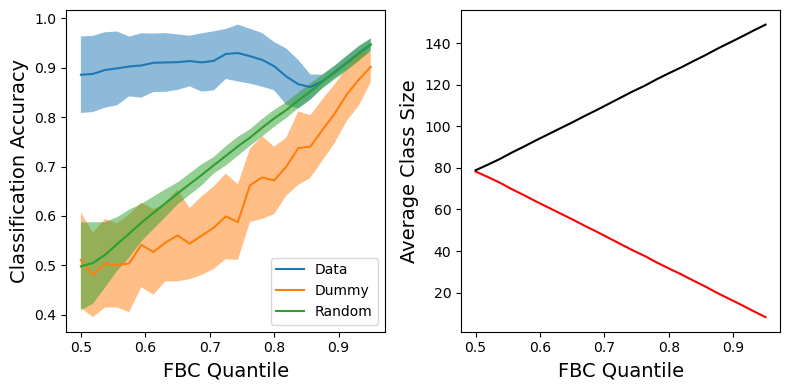

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(fbc_fraction, np.mean(scores, axis=(1, 2)))
ax[0].fill_between(fbc_fraction, np.mean(scores, axis=(1, 2)) - np.std(scores, axis=(1, 2)), np.mean(scores, axis=(1, 2)) + np.std(scores, axis=(1, 2)), alpha=0.5)

ax[0].plot(fbc_fraction, np.mean(dummy_scores, axis=(1, 2)))
ax[0].fill_between(fbc_fraction, np.mean(dummy_scores, axis=(1, 2)) - np.std(dummy_scores, axis=(1, 2)), np.mean(dummy_scores, axis=(1, 2)) + np.std(dummy_scores, axis=(1, 2)), alpha=0.5)

ax[0].plot(fbc_fraction, np.mean(random_scores, axis=(1, 2, 3)))
ax[0].fill_between(fbc_fraction, np.mean(random_scores, axis=(1, 2, 3)) - np.std(random_scores, axis=(1, 2, 3)), np.mean(random_scores, axis=(1, 2, 3)) + np.std(random_scores, axis=(1, 2, 3)), alpha=0.5)

ax[0].legend(['Data', 'Dummy', 'Random'], loc='lower right')
ax[0].set_xlabel('FBC Quantile', fontsize=14)
ax[0].set_ylabel('Classification Accuracy', fontsize=14)

ax[1].plot(fbc_fraction, np.mean(class_sizes[:, :, 0], axis=1), color='r')
ax[1].plot(fbc_fraction, np.mean(class_sizes[:, :, 1], axis=1), color='k')
ax[1].set_xlabel('FBC Quantile', fontsize=14)
ax[1].set_ylabel('Average Class Size', fontsize=14)
fig.tight_layout()
#fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/cc_clusteringS1.pdf', bbox_inches='tight', pad_inches=1)

In [15]:
# P-value test at 0.5
scipy.stats.mannwhitneyu(np.mean(scores[0, ...], axis=-1), np.mean(random_scores[0, ...], axis=2).ravel(), alternative='greater')

MannwhitneyuResult(statistic=320.0, pvalue=5.10508126563125e-06)

In [16]:
# Scatter this for fbc fraction = 0.5
fbcf = 0.5
su_r = np.zeros((len(carray), 2, carray[0].shape[1]))
keys = ['FCCA_loadings', 'PCA_loadings']

X = []
Yf = []
Yp = []

# Per recording session
x_ = []
yf_ = []
yp_ = []

# Is a neuron more FBC or FFC?
ntype = []

for i in range(len(carray)):
    for j in range(2):
        df = apply_df_filters(itrim_df, data_file=data_files[i])
        x1 = df[keys[j]].values

        if j == 0:
            Yf.extend(x1)
            yf_.append(x1)
        else:
            Yp.extend(x1)
            yp_.append(x1)

        xx = []
        xall = np.vstack(xall)
        for k in range(carray[0].shape[1]):
            x2 = carray[i][:, k]
            xx.append(x2)
            su_r[i, j, k] = scipy.stats.spearmanr(x1, x2)[0]
    
        xx = np.array(xx).T            

    rfbc = yf_[-1]/(yf_[-1] + yp_[-1])
    rffc = yp_[-1]/(yf_[-1] + yp_[-1])

    for n in range(rfbc.size):
        if rfbc[n] > fbcf:
            ntype.append(0)
        else:
            ntype.append(1)

    # ntype.extend(np.argmax(np.vstack([rfbc[np.newaxis, :], rffc[np.newaxis, :]]), axis=0))
    X.append(xx)
    x_.append(xx)


X = np.vstack(X)
Yf = np.array(Yf)[:, np.newaxis]                                         
Yp = np.array(Yp)[:, np.newaxis]

NameError: name 'xall' is not defined

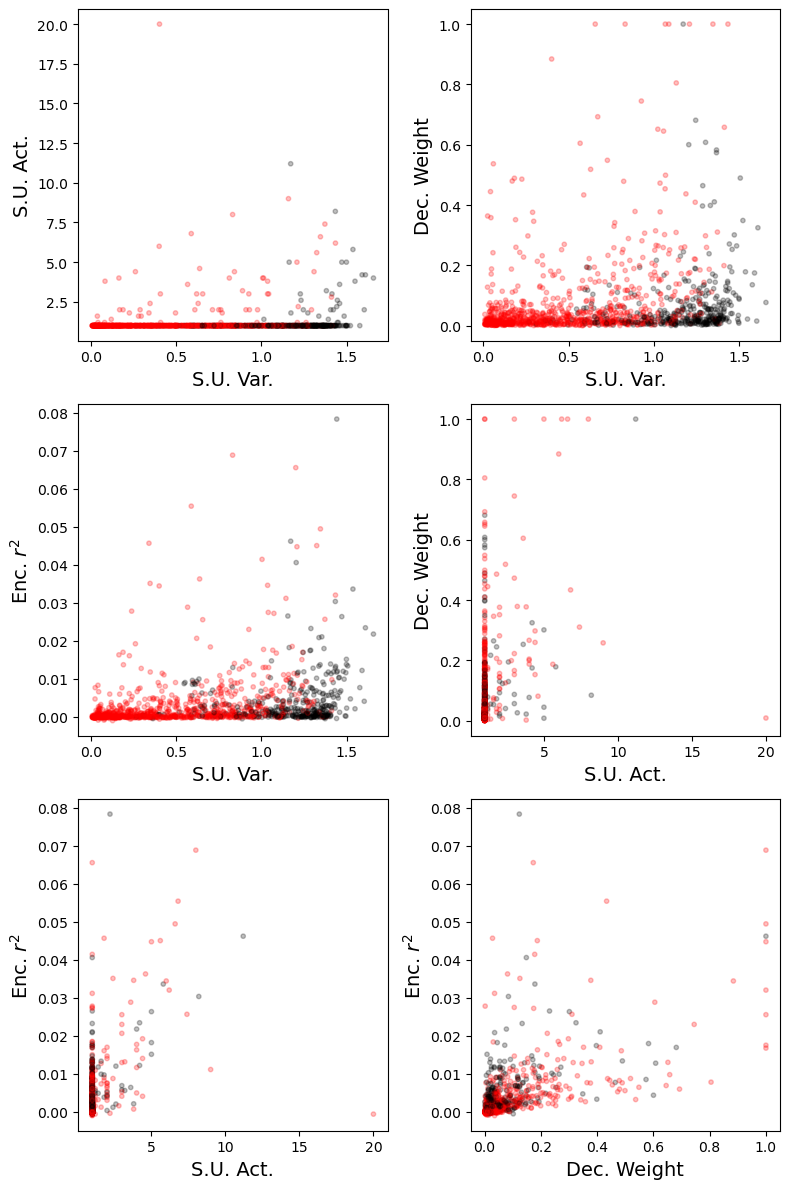

In [ ]:
# Color by ntype
fig, ax = plt.subplots(3, 2, figsize=(8, 12))
colors = ['r' if n == 0 else 'k' for n in ntype]
stats = ['su_var', 'su_act', 'decoding_weights', 'su_r2_enc']
stat_strings = ['S.U. Var.', 'S.U. Act.', 'Dec. Weight', 'Enc. ' +  r'$r^2$']
for i, comb in enumerate(itertools.combinations(np.arange(4), 2)):
    a = ax[np.unravel_index(i, (3, 2))]
    a.scatter(X[:, comb[0]], X[:, comb[1]], c=colors, alpha=0.25, s=10)
    a.set_xlabel(stat_strings[comb[0]], fontsize=14)
    a.set_ylabel(stat_strings[comb[1]], fontsize=14)
fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/cc_clustering_scatterS1.pdf', bbox_inches='tight', pad_inches=1)

In [17]:
xall = []
T = 30
time = np.arange(T)
for h, data_file in enumerate(data_files):
    dat = load_sabes('%s/%s' % (data_path, data_file), boxcox=None, high_pass=False, region='S1')
    dat_segment = reach_segment_sabes(dat, data_file=data_file.split('.mat')[0])
    t = np.array([t_[1] - t_[0] for t_ in dat_segment['transition_times']])
    valid_transitions = np.arange(t.size)[t >= T]
        
    # Store trajectories for subsequent pairwise analysis
    n = dat['spike_rates'].shape[-1]
    x = np.zeros((n, time.size))
    for j in range(n):
        x_ = np.array([dat['spike_rates'][0, dat_segment['transition_times'][idx][0]:dat_segment['transition_times'][idx][0] + T, j] 
                    for idx in valid_transitions])
        #x_ = StandardScaler().fit_transform(x_.T).T
        x_ = gaussian_filter1d(x_, sigma=2)
        x_ = np.mean(x_, axis=0)
        x[j, :] = x_
    xall.append(x)

96
Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


96
Reminder that start times depend on the bin size
96
Reminder that start times depend on the bin size
96
Reminder that start times depend on the bin size
96
Reminder that start times depend on the bin size
96
Reminder that start times depend on the bin size
96
Reminder that start times depend on the bin size
96
Reminder that start times depend on the bin size


In [18]:
xall_stacked = np.vstack(xall)

In [19]:
# vary umap dimreduc dimensionality and other hyperparameters
# ncomp = np.arange(1, 6)
# min_dist = np.array([0.01, 0.05, 0.1, 0.2, 0.25, 0.5])
# n_neighbors = np.array([5, 25, 50, 100])
param = (4, 0.2, 50)
# Share the UMAP projection across recording sessions - measure classificationa ccuraacy per recording session
fit = umap.UMAP(min_dist=param[1], n_neighbors=param[2], n_components=param[0])
u = fit.fit_transform(xall_stacked)

In [20]:

fbc_fraction = np.linspace(0.5, 0.95, 25)
ncv = 5
nrandom = 100
# Partition by data file
scores = np.zeros((len(fbc_fraction), len(carray), ncv))
dummy_scores = np.zeros((len(fbc_fraction), len(carray), ncv))
random_scores = np.zeros((len(fbc_fraction), len(carray), ncv, nrandom))

indices = list(np.cumsum([len(x_) for x_ in xall]))
indices.insert(0, 0)

for ii, fbcf in tqdm(enumerate(fbc_fraction)):
    for i in range(len(xall)):

        # Per recording session
        yf_ = []
        yp_ = []

        # Is a neuron more FBC or FFC?
        ntype = []

        for j in range(2):
            df = apply_df_filters(itrim_df, data_file=data_files[i])
            x1 = df[keys[j]].values
            xx = []

            if j == 0:
                yf_.append(x1)
            else:
                yp_.append(x1)

        rfbc = yf_[-1]/(yf_[-1] + yp_[-1])
        rffc = yp_[-1]/(yf_[-1] + yp_[-1])

        # do this by quantile
        cutoff = np.quantile(rfbc, fbcf)
        for n in range(rfbc.size):
            if rfbc[n] > cutoff:
                ntype.append(0)
            else:
                ntype.append(1)

        # get the
        u_i = u[indices[i]:indices[i+1], :]
        logreg = LogisticRegression()
        # perform 10-fold cross-validation
        scores[ii, i] = cross_val_score(logreg, u_i, ntype, cv=ncv)
        dummy_scores[ii, i] = cross_val_score(DummyClassifier(strategy='stratified'), u_i, ntype, cv=ncv)

        # Compare also to 100 random assignments of neuron types
        for k in range(nrandom):
            ntype_rand = np.random.permutation(ntype)
            random_scores[ii, i, :, k] = cross_val_score(logreg, u_i, ntype_rand, cv=ncv)

0it [00:00, ?it/s]

25it [03:33,  8.53s/it]


In [19]:
with open('cc_clusteringS1umap_results.pkl', 'wb') as f:
    f.write(pickle.dumps(scores))
    f.write(pickle.dumps(dummy_scores))
    f.write(pickle.dumps(random_scores))
    #f.write(pickle.dumps(class_sizes))

Text(0, 0.5, 'Classification Accuracy')

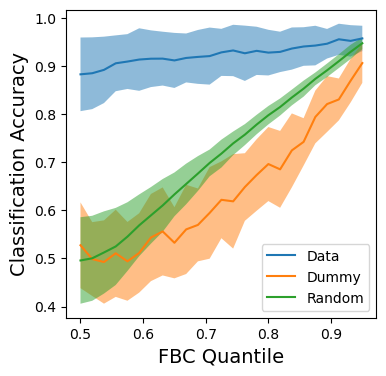

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(fbc_fraction, np.mean(scores, axis=(1, 2)))
ax.fill_between(fbc_fraction, np.mean(scores, axis=(1, 2)) - np.std(scores, axis=(1, 2)), np.mean(scores, axis=(1, 2)) + np.std(scores, axis=(1, 2)), alpha=0.5)

ax.plot(fbc_fraction, np.mean(dummy_scores, axis=(1, 2)))
ax.fill_between(fbc_fraction, np.mean(dummy_scores, axis=(1, 2)) - np.std(dummy_scores, axis=(1, 2)), np.mean(dummy_scores, axis=(1, 2)) + np.std(dummy_scores, axis=(1, 2)), alpha=0.5)

ax.plot(fbc_fraction, np.mean(random_scores, axis=(1, 2, 3)))
ax.fill_between(fbc_fraction, np.mean(random_scores, axis=(1, 2, 3)) - np.std(random_scores, axis=(1, 2, 3)), np.mean(random_scores, axis=(1, 2, 3)) + np.std(random_scores, axis=(1, 2, 3)), alpha=0.5)

ax.legend(['Data', 'Dummy', 'Random'], loc='lower right')
ax.set_xlabel('FBC Quantile', fontsize=14)
ax.set_ylabel('Classification Accuracy', fontsize=14)

# ax[1].plot(fbc_fraction, np.mean(class_sizes[:, :, 0], axis=1), color='r')
# ax[1].plot(fbc_fraction, np.mean(class_sizes[:, :, 1], axis=1), color='k')
# ax[1].set_xlabel('FBC Quantile', fontsize=14)
# ax[1].set_ylabel('Average Class Size', fontsize=14)
# fig.tight_layout()
#fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/umap_clusteringS1.pdf', bbox_inches='tight', pad_inches=1)

In [22]:
#LDA 
# Visualize results using LDA

fbc_fraction = np.linspace(0.5, 0.95, 25)
ncv = 5
nrandom = 100
# Partition by data file
scores = np.zeros((len(fbc_fraction), len(carray), ncv))
dummy_scores = np.zeros((len(fbc_fraction), len(carray), ncv))
random_scores = np.zeros((len(fbc_fraction), len(carray), ncv, nrandom))
keys = ['FCCA_loadings', 'PCA_loadings']
indices = list(np.cumsum([len(x_) for x_ in xall]))
indices.insert(0, 0)

for ii, fbcf in tqdm(enumerate(fbc_fraction)):
    for i in range(len(xall)):

        # Per recording session
        yf_ = []
        yp_ = []

        # Is a neuron more FBC or FFC?
        ntype = []

        for j in range(2):
            df = apply_df_filters(itrim_df, data_file=data_files[i])
            x1 = df[keys[j]].values
            xx = []

            if j == 0:
                yf_.append(x1)
            else:
                yp_.append(x1)

        rfbc = yf_[-1]/(yf_[-1] + yp_[-1])
        rffc = yp_[-1]/(yf_[-1] + yp_[-1])

        # do this by quantile
        cutoff = np.quantile(rfbc, fbcf)
        for n in range(rfbc.size):
            if rfbc[n] > cutoff:
                ntype.append(0)
            else:
                ntype.append(1)

        # get the
        u_i = u[indices[i]:indices[i+1], :]
        #logreg = LogisticRegression()
        lda = LinearDiscriminantAnalysis(n_components=1)
        # perform 10-fold cross-validation
        scores[ii, i] = cross_val_score(lda, u_i, ntype, cv=ncv)
        dummy_scores[ii, i] = cross_val_score(DummyClassifier(strategy='stratified'), u_i, ntype, cv=ncv)

        # Compare also to 100 random assignments of neuron types
        for k in range(nrandom):
            ntype_rand = np.random.permutation(ntype)
            random_scores[ii, i, :, k] = cross_val_score(lda, u_i, ntype_rand, cv=ncv)

0it [00:00, ?it/s]

25it [01:13,  2.93s/it]


In [8]:
# with open('cc_clusteringS1umapLDA_results.pkl', 'wb') as f:
#     f.write(pickle.dumps(scores))
#     f.write(pickle.dumps(dummy_scores))
#     f.write(pickle.dumps(random_scores))
    #f.write(pickle.dumps(class_sizes))
fbc_fraction = np.linspace(0.5, 0.95, 25)
with open('cc_clusteringS1umapLDA_results.pkl', 'rb') as f:
    scores = pickle.load(f)
    dummy_scores = pickle.load(f)
    random_scores = pickle.load(f)

Text(0, 0.5, 'Classification Accuracy')

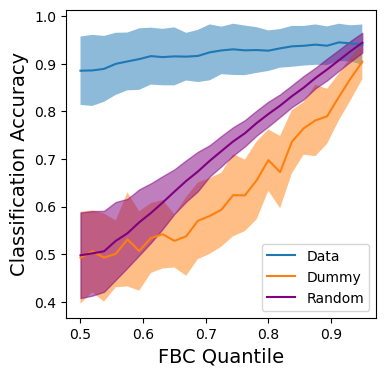

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(fbc_fraction, np.mean(scores, axis=(1, 2)))
ax.fill_between(fbc_fraction, np.mean(scores, axis=(1, 2)) - np.std(scores, axis=(1, 2)), np.mean(scores, axis=(1, 2)) + np.std(scores, axis=(1, 2)), alpha=0.5)

ax.plot(fbc_fraction, np.mean(dummy_scores, axis=(1, 2)))
ax.fill_between(fbc_fraction, np.mean(dummy_scores, axis=(1, 2)) - np.std(dummy_scores, axis=(1, 2)), np.mean(dummy_scores, axis=(1, 2)) + np.std(dummy_scores, axis=(1, 2)), alpha=0.5)

ax.plot(fbc_fraction, np.mean(random_scores, axis=(1, 2, 3)), color='purple')
ax.fill_between(fbc_fraction, np.mean(random_scores, axis=(1, 2, 3)) - np.std(random_scores, axis=(1, 2, 3)), np.mean(random_scores, axis=(1, 2, 3)) + np.std(random_scores, axis=(1, 2, 3)), alpha=0.5, color='purple')

ax.legend(['Data', 'Dummy', 'Random'], loc='lower right')
ax.set_xlabel('FBC Quantile', fontsize=14)
ax.set_ylabel('Classification Accuracy', fontsize=14)

# ax[1].plot(fbc_fraction, np.mean(class_sizes[:, :, 0], axis=1), color='r')
# ax[1].plot(fbc_fraction, np.mean(class_sizes[:, :, 1], axis=1), color='k')
# ax[1].set_xlabel('FBC Quantile', fontsize=14)
# ax[1].set_ylabel('Average Class Size', fontsize=14)
# fig.tight_layout()
# fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/umap_clusteringS1LDA.pdf', bbox_inches='tight', pad_inches=1)

In [24]:
# Run LDA on everything aggregated and visualize
# Visualize results using LDA

ncv = 5
nrandom = 100
keys = ['FCCA_loadings', 'PCA_loadings']
indices = list(np.cumsum([len(x_) for x_ in xall]))
indices.insert(0, 0)
itrim_df = loadings_df
fbcf = 0.5
# Is a neuron more FBC or FFC?
ntype = []
for i in range(len(xall)):

    # Per recording session
    yf_ = []
    yp_ = []


    for j in range(2):
        df = apply_df_filters(itrim_df, data_file=data_files[i])
        x1 = df[keys[j]].values
        xx = []

        if j == 0:
            yf_.append(x1)
        else:
            yp_.append(x1)

    rfbc = yf_[-1]/(yf_[-1] + yp_[-1])
    rffc = yp_[-1]/(yf_[-1] + yp_[-1])

    # do this by quantile
    cutoff = np.quantile(rfbc, fbcf)
    for n in range(rfbc.size):
        if rfbc[n] > cutoff:
            ntype.append(0)
        else:
            ntype.append(1)

In [25]:
lda = LinearDiscriminantAnalysis(n_components=1)
xtrans = lda.fit_transform(u, ntype)

In [26]:
from matplotlib import cm
carray = cm.RdGy(range(256))

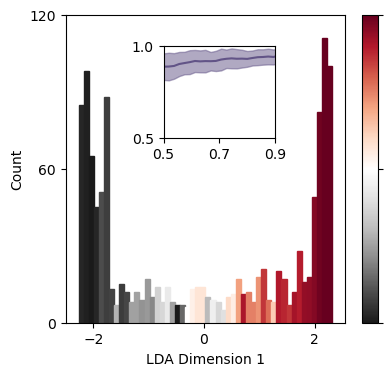

In [30]:
# Color by type
fig, ax = plt.subplots(figsize=(4.5, 4))
N, bins, patches = ax.hist(xtrans, linewidth=1, bins=50)
xbinned = np.digitize(xtrans, bins).squeeze()
# Set each rectangle to a color gradient set by the fraction of entries that belong to each type
for i in range(len(patches)):
    x_ = np.where(xbinned == i + 1)[0]
    ntype_ = np.array(ntype)[x_]
    frac = np.sum(ntype_)/x_.size
    patches[i].set_facecolor(carray[int(255 * frac)])
    patches[i].set_edgecolor(carray[int(255 * frac)])
    #patches[i].set_facecolor(carray[0])
ax.set_xlabel('LDA Dimension 1')
ax.set_ylabel('Count')
ax.set_xticks([-2, 0, 2])
ax.set_yticks([0, 60, 120])
cmap = cm.RdGy.reversed()
norm = colors.Normalize(vmin=0, vmax=1)
cbar= fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='vertical', label='', ticks=[0, 0.5, 1.0])
#cbar.ax.set_yticks([0, 0.5, 1.0])
cbar.ax.set_yticklabels([])

axin = ax.inset_axes([0.35, 0.6, 0.4, 0.3])
# axin.set_aspect(1)
axin.set_ylim([0.5, 1.0])
axin.set_xlim([0.5, 0.9])
axin.set_yticks([0.5, 1.0])
axin.set_xticks([0.5, 0.7, 0.9])
axin.plot(fbc_fraction, np.mean(scores, axis=(1, 2)), color='#625487')
axin.fill_between(fbc_fraction, np.mean(scores, axis=(1, 2)) - np.std(scores, axis=(1, 2)), np.mean(scores, axis=(1, 2)) + np.std(scores, axis=(1, 2)), alpha=0.5, color='#625487')
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/s1_lda_viz.pdf', bbox_inches='tight', pad_inches=0)

In [24]:
from sklearn.metrics import accuracy_score